In [1]:
import yfinance as yf
from datetime import date

symbol = 'BTC-USD'
start_date = '2014-09-17'
end_date = date.today().strftime('%Y-%m-%d')
datacsv = yf.download(symbol, start=start_date, end=end_date)

# Save the data to a CSV file
datacsv.to_csv(f"{symbol}.csv")

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


In [2]:
#importing required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
#to plot within notebook
import matplotlib.pyplot as plt

In [3]:

# function to calculate percentage difference considering baseValue as 100%
def percentageChange(baseValue, currentValue):
    return((float(currentValue)-baseValue) / abs(baseValue)) *100.00

# function to get the actual value using baseValue and percentage
def reversePercentageChange(baseValue, percentage):
    return float(baseValue) + float(baseValue * percentage / 100.00)

# function to transform a list of values into the list of percentages. For calculating percentages for each element in the list
# the base is always the previous element in the list.
def transformToPercentageChange(x):
    baseValue = x[0]
    x[0] = 0
    for i in range(1,len(x)):
        pChange = percentageChange(baseValue,x[i])
        baseValue = x[i]
        x[i] = pChange

# function to transform a list of percentages to the list of actual values. For calculating actual values for each element in the list
# the base is always the previous calculated element in the list.
def reverseTransformToPercentageChange(baseValue, x):
    x_transform = []
    for i in range(0,len(x)):
        value = reversePercentageChange(baseValue,x[i])
        baseValue = value
        x_transform.append(value)
    return x_transform

#read the data file
df = pd.read_csv('/content/BTC-USD.csv')
start_date = '2014-09-17'
# store the first element in the series as the base value for future use.
baseValue = df['Close'][0]

# create a new dataframe which is then transformed into relative percentages
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

# transform the 'Close' series into relative percentages
transformToPercentageChange(new_data['Close'])

# set Dat column as the index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

# create train and test sets
dataset = new_data.values
train, valid = train_test_split(dataset, train_size=0.99, test_size=0.01, shuffle=False)

# convert dataset into x_train and y_train.
# prediction_window_size is the size of days windows which will be considered for predicting a future value.
prediction_window_size = 60
x_train, y_train = [], []
for i in range(prediction_window_size,len(train)):
    x_train.append(dataset[i-prediction_window_size:i,0])
    y_train.append(dataset[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

##################################################################################################
# create and fit the LSTM network
# Initialising the RNN
model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')


print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

Epoch 1/256
27/27 [==============================] - 10s 22ms/step - loss: 13.6533
Epoch 2/256
27/27 [==============================] - 0s 15ms/step - loss: 13.6441
Epoch 3/256
27/27 [==============================] - 0s 15ms/step - loss: 13.6391
Epoch 4/256
27/27 [==============================] - 0s 15ms/step - loss: 13.6106
Epoch 5/256
27/27 [==============================] - 0s 15ms/step - loss: 13.6176
Epoch 6/256
27/27 [==============================] - 0s 15ms/step - loss: 13.6151
Epoch 7/256
27/27 [==============================] - 0s 15ms/step - loss: 13.6028
Epoch 8/256
27/27 [==============================] - 0s 15ms/step - loss: 13.6195
Epoch 9/256
27/27 [==============================] - 0s 15ms/step - loss: 13.6176
Epoch 10/256
27/27 [==============================] - 0s 15ms/step - loss: 13.6279
Epoch 11/256
27/27 [==============================] - 0s 15ms/step - loss: 13.5981
Epoch 12/256
27/27 [==============================] - 0s 15ms/step - loss: 13.6025
Epoch 13/256

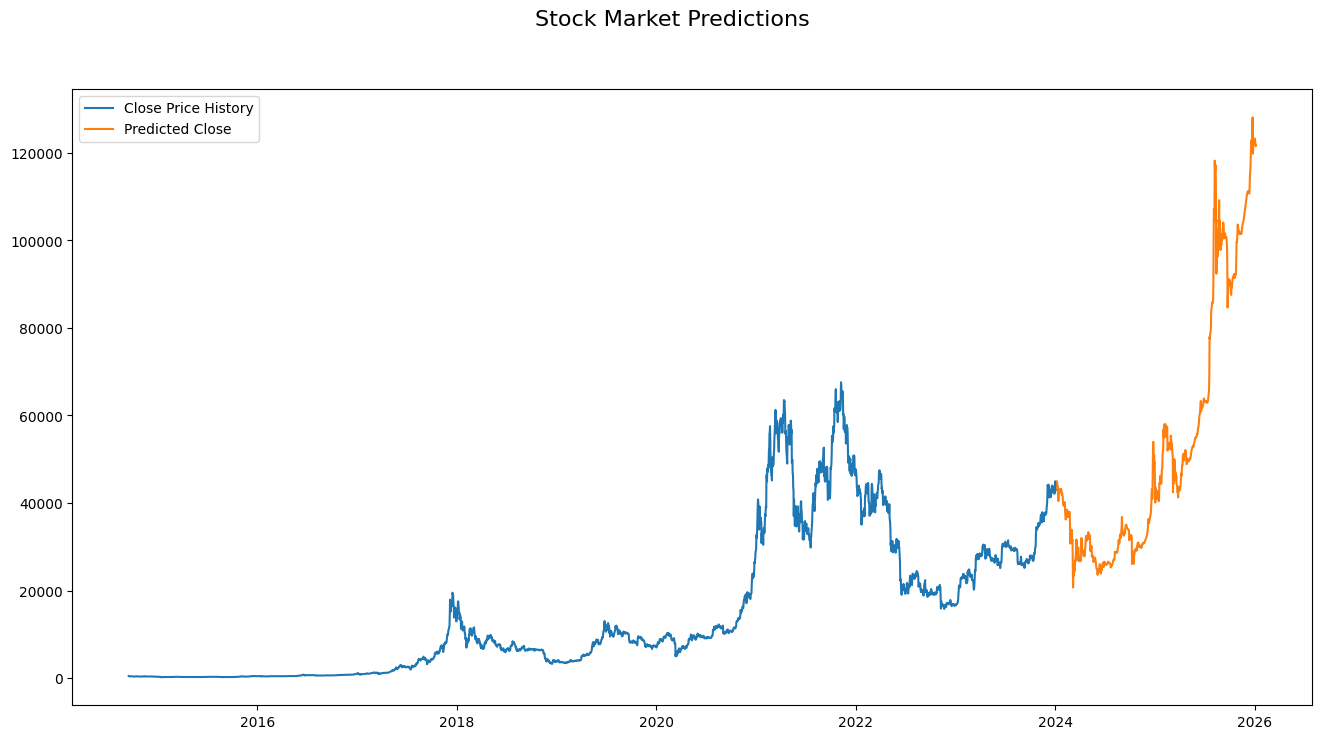

In [4]:
# Fitting the RNN to the Training set
model.fit(x_train, y_train, epochs = 256, batch_size = 128)

##################################################################################################


#predicting future values, using past 60 from the train data
# for next 10 yrs total_prediction_days is set to 3650 days
total_prediction_days = 3650
inputs = new_data[-total_prediction_days:].values
inputs = inputs.reshape(-1,1)

# create future predict list which is a two dimensional list of values.
# the first dimension is the total number of future days
# the second dimension is the list of values of prediction_window_size size

X_predict = []
for i in range(prediction_window_size,inputs.shape[0]):
    X_predict.append(inputs[i-prediction_window_size:i,0])
X_predict = np.array(X_predict)

X_predict = X_predict.astype('float32')
# predict the future
X_predict = np.reshape(X_predict, (X_predict.shape[0],X_predict.shape[1],1))
future_closing_price = model.predict(X_predict)

train, valid = train_test_split(new_data, train_size=0.99, test_size=0.01, shuffle=False)
date_index = pd.to_datetime(train.index)

#converting dates into number of days as dates cannot be passed directly to any regression model
x_days = (date_index - pd.to_datetime(start_date)).days

# we are doing prediction for next 5 years hence prediction_for_days is set to 1500 days.
prediction_for_days = 365*2
future_closing_price = future_closing_price[:prediction_for_days]

# create a data index for future dates
x_predict_future_dates = np.asarray(pd.RangeIndex(start=x_days[-1] + 1, stop=x_days[-1] + 1 + (len(future_closing_price))))
future_date_index = pd.to_datetime(x_predict_future_dates, origin=start_date, unit='D')

# transform a list of relative percentages to the actual values
train_transform = reverseTransformToPercentageChange(baseValue, train['Close'])

# for future dates the base value the the value of last element from the training set.
baseValue = train_transform[-1]
valid_transform = reverseTransformToPercentageChange(baseValue, valid['Close'])
future_closing_price_transform = reverseTransformToPercentageChange(baseValue, future_closing_price)

# recession peak date is the date on which the index is at the bottom most position.
recessionPeakDate =  future_date_index[future_closing_price_transform.index(min(future_closing_price_transform))]
minCloseInFuture = min(future_closing_price_transform)
print("The stock market will reach to its lowest bottom on", recessionPeakDate)
print("The lowest index the stock market will fall to is ", minCloseInFuture)

# plot the graphs
plt.figure(figsize=(16,8))
df_x = pd.to_datetime(new_data.index)
plt.plot(date_index,train_transform, label='Close Price History')
plt.plot(future_date_index,future_closing_price_transform, label='Predicted Close')

# set the title of the graph
plt.suptitle('Stock Market Predictions', fontsize=16)

# set the title of the graph window
#fig = plt.gcf()
#fig.canvas.set_window_title('Stock Market Predictions')
#display the legends
plt.legend()

#display the graph
plt.show()

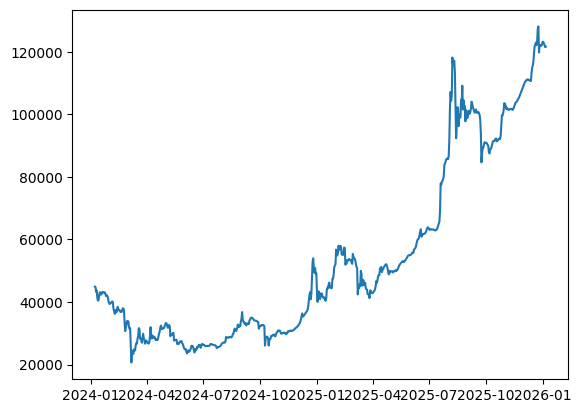

In [5]:
import matplotlib.pyplot as plt
import pickle

# Create your plot
fig, ax = plt.subplots()
ax.plot(future_date_index,future_closing_price_transform)

# Save the figure
with open('figure_all.pkl', 'wb') as file:
    pickle.dump(fig, file)


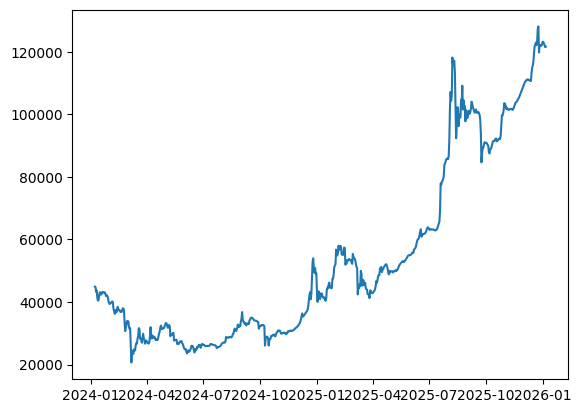

In [6]:
import pickle

# Load the figure
with open('figure_all.pkl', 'rb') as file:
    fig = pickle.load(file)

fig.show()


In [7]:
import matplotlib
print(matplotlib.__version__)


3.7.1
